# Laboratory 3: Detecting and mitigating bias and uncertainty in Facial Detection Systems
In this lab, we'll continue to explore how to mitigate algorithmic bias in facial recognition systems. In addition, we'll explore the notion of *uncertainty* in datasets, and learn how to reduce both data-based and model-based uncertainty.

As we've seen in lecture 5, bias and uncertainty underlie many common issues with machine learning models today, and these are not just limited to classification tasks. Automatically detecting and mitigating uncertainty is crucial to deploying fair and safe models. 

In this lab, we'll be using [CAPSA](https://github.com/themis-ai/capsa/), a software package developed by [Themis AI](https://themisai.io/), which automatically *wraps* models to make them risk-aware and plugs into training workflows. We'll explore how we can use CAPSA to diagnose uncertainties, and then develop methods for automatically mitigating them.


Run the next code block for a short video from Google that explores how and why it's important to consider bias when thinking about machine learning:

Let's get started by installing the relevant dependencies:

In [1]:
# Import Tensorflow 2.0
#%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
#!pip install mitdeeplearning
import lab3
# Download and import capsa
#!pip install capsa
from capsa import *

## 3.1 Datasets

We'll be using the same datasets from lab 2 in this lab. Note that in this dataset, we've intentionally perturbed some of the samples in some ways (it's up to you to figure out how!) that are not necessarily present in the actual dataset. 

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). Many images across many different categories. We'll take negative examples from a variety of non-human categories. 
[Fitzpatrick Scale](https://en.wikipedia.org/wiki/Fitzpatrick_scale) skin type classification system, with each image labeled as "Lighter'' or "Darker''.

Like before, let's begin by importing these datasets. We've written a class that does a bit of data pre-processing to import the training data in a usable format.

Also note that in this lab, we'll be using a much larger test dataset for evaluation purposes.

In [2]:
batch_size = 32

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face_2023_v2.h5', 'https://www.dropbox.com/s/b5z1cd317y5u1tr/train_face_2023_v2.h5?dl=1')
# Instantiate a DatasetLoader using the downloaded dataset
train_loader = lab3.DatasetLoader(path_to_training_data, training=True, batch_size= batch_size)
test_loader = lab3.DatasetLoader(path_to_training_data, training=False, batch_size = batch_size)

Opening /home/sadhanalolla/.keras/datasets/train_face_2023_v2.h5
Loading data into memory...
Opening /home/sadhanalolla/.keras/datasets/train_face_2023_v2.h5
Loading data into memory...


### Recap: Thinking about bias and uncertainty

Remember that we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. Our goal is to build a model that trains on CelebA *and* achieves high classification accuracy on the the test dataset across all demographics, and to thus show that this model does not suffer from any hidden bias. 

In addition to thinking about bias, we want to detect areas of high *aleatoric* uncertainty in the dataset, which is defined as data noise: in the context of facial detection, this means that we may have very similar inputs with different labels-- think about the scenario where one face is labeled correctly as a positive, and another face is labeled incorrectly as a negative. 

Finally, we want to look at samples with high *epistemic*, or predictive, uncertainty. These may be samples that are anomalous or out of distribution, samples that contain adversarial noise, or samples that are "harder" to learn in some way. Importantly, epistemic uncertainty is not the same as bias! We may have well-represented samples that still have high epistemic uncertainty. 

# 3.2 Bias

In the previous lab, we used a variational autoencoder (VAE) to automatically learn the latent structure of our database, and we developed a scoring mechanism for samples to determine their bias. In this lab, we'll show that we can use CAPSA to do the same thing in one line! Then, our goal will be to continue our implementation of the DB-VAE and use the latent variables learned via a VAE to adaptively re-sample the CelebA data during training. Specifically, we will alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data).

Just like the last lab, let's define a standard classifier that we'll use as the base encoder of our network.

In [3]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([ 
    tf.keras.Input(shape=(64,64, 3)),
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

Let's use CAPSA's `HistogramVAEWrapper` to analyze the latent space distribution as we did previously. The `HistogramVAEWrapper` constructs a histogram with `num_bins` bins across every dimension of the latent space, and then calculates the joint probability of every sample according to the histograms. The samples with the lowest joint probability have the lowest bias, and we want to oversample these. Conversely, we want to undersample the areas of the dataset with the highest bias.

The `HistogramVAEWrapper` class takes in a number of arguments: namely, the number of bins we want to discretize our distribution into, the number of samples we want to track at any given point, and whether we're using the output of a hidden layer (good for higher-dimensional data) or the input data itself (good for lower-dimensional data). Since this is a variational autoencoder, we need to also pass in a decoder. Let's define the same decoder as the previous lab:

In [4]:
def make_face_decoder_network(n_filters=12):
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [5]:
standard_classifier = make_standard_classifier()
wrapped_classifier = HistogramVAEWrapper(standard_classifier, num_bins=5, queue_size=20000, latent_dim = 100, decoder=make_face_decoder_network())

Now, let's train the wrapped classifier! As we did in the previous lab, in addition to updating the weights of the model, the wrapped classifier also tracks feature distributions. We can use the joint probabilities of these feature distributions to determine the bias of a given sample in this dataset. We'll make use of the `Model.fit` API here, but note that we can achieve the same behavior with a custom training loop as well.

In [6]:
learning_rate = 1e-5

# compile model using desired optimizers and losses
wrapped_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
    run_eagerly=True
)

# fit the model to our training data
history = wrapped_classifier.fit(
        train_loader,
        epochs=6,
        batch_size=batch_size,
  )

Epoch 1/6
2404/2404 [==============================] - 12s 4ms/step - vae_compiled_loss: 0.6538 - vae_compiled_binary_accuracy: 0.6221 - vae_wrapper_loss: 1120.5728
Epoch 2/6
2404/2404 [==============================] - 10s 4ms/step - vae_compiled_loss: 0.3118 - vae_compiled_binary_accuracy: 0.8758 - vae_wrapper_loss: 414.2382
Epoch 3/6
2404/2404 [==============================] - 10s 4ms/step - vae_compiled_loss: 0.2276 - vae_compiled_binary_accuracy: 0.9161 - vae_wrapper_loss: 330.7279
Epoch 4/6
2404/2404 [==============================] - 10s 4ms/step - vae_compiled_loss: 0.1940 - vae_compiled_binary_accuracy: 0.9305 - vae_wrapper_loss: 290.0597
Epoch 5/6
2404/2404 [==============================] - 11s 4ms/step - vae_compiled_loss: 0.1702 - vae_compiled_binary_accuracy: 0.9405 - vae_wrapper_loss: 268.3271
Epoch 6/6
2404/2404 [==============================] - 11s 5ms/step - vae_compiled_loss: 0.1465 - vae_compiled_binary_accuracy: 0.9502 - vae_wrapper_loss: 253.0845


Let's see what the bias looks like on our test dataset! Note that in this lab, we're using a much larger test dataset than the one in Lab 2. By calling the `wrapped_classifier` on our test set, we can automatically generate the same bias scores that we manually calculated in the last lab. 

In [7]:
test_imgs = test_loader.get_all_faces() # Get all faces from the testing dataset
predictions, _, bias = wrapped_classifier.predict(test_imgs) # use CAPSA-wrapped classifier to obtain estimates for bias and the output

516/516 [==============================] - 49s 96ms/step


In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Now, we have an estimate for the bias score! Let's visualize what the samples with the highest bias and those with the lowest bias look like. Before you run the next code block, which faces would you expect to be underrepresented in the dataset? Which ones do you think will be overrepresented?

In [9]:
indices = np.argsort(bias, axis=None) 
sorted_images = test_imgs[indices] # sort images from lowest to highest bias
sorted_biases = bias[indices]
sorted_preds = predictions[indices]

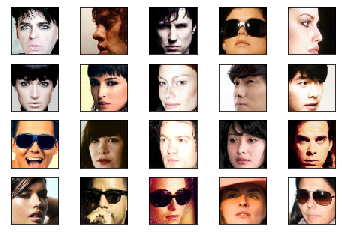

<Figure size 432x288 with 0 Axes>

In [10]:
lab3.plot_k(sorted_images[:20]) # These are the samples with the lowest representation (least bias) in our test dataset

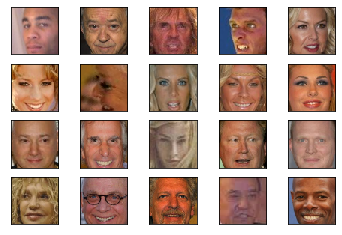

<Figure size 432x288 with 0 Axes>

In [11]:
lab3.plot_k(sorted_images[-20:]) # These are the samples with the highest representation (most bias) in our test dataset

Now, we'll spend some time looking at the bias by *percentile* in our dataset. First, let's plot the accuracy as the bias increases. Remember that we use bias to quantify the level of representation in our dataset, so increasing bias means increasing representation. How do you expect the accuracy to change?

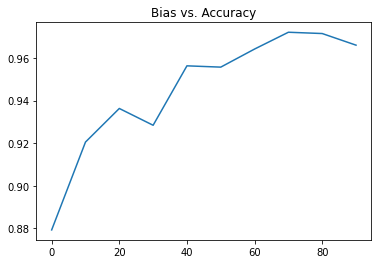

<Figure size 432x288 with 0 Axes>

In [12]:
averaged_imgs = lab3.plot_accuracy_vs_risk(sorted_images, sorted_biases, sorted_preds, "Bias vs. Accuracy")

Now, for a super interesting visualization, let's look at the *percentiles* of bias: what does the average face in the 10th percentile of bias look like? What about the 90th percentile? What changes across these faces?

<Figure size 432x288 with 0 Axes>

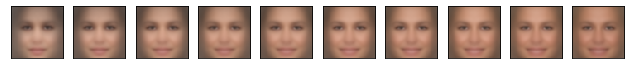

In [13]:
lab3.plot_percentile(averaged_imgs)

Now that we know what the bias in our dataset looks like, let's adaptively resample from our dataset! Since we can calculate this score on-the-fly *during training*, we can adjust the probability of samples being chosen. But first, let's also take a look at the *epistemic* uncertainty of this dataset

# 3.3 Epistemic Uncertainty

Recall from lecture that *epistemic* uncertainty, or a model's uncertainty in its prediction, can arise from out of distribution data, or samples that are harder to learn. This does not necessarily correlate with bias! Imagine the scenario of training an object detector for self-driving cars: even if the model is presented with many cluttered scenes, these samples still may be harder to learn than scenes with very few objects in them. In this part of the lab, we'll analyze the epistemic uncertainty of the VAE that we've trained on this dataset. 

From lecture 6, we saw that most methods of estimating epistemic uncertainty are *sampling-based*, but we can also use *reconstruction-based* methods. If a model is unable to provide a good reconstruction for a given data point, it has not learned that area of the underlying data distribution well, and therefore has high epistemic uncertainty. 

Since we've already used a VAE to calculate the histograms for bias quantification, we can use the same VAE to shed insight into epistemic uncertainty! CAPSA helps us do exactly that: when call the model, we get the bias, reconstruction loss, and prediction for every sample.

In [14]:
predictions, reconstruction_loss, bias = wrapped_classifier.predict(test_imgs) # note that we're estimating both bias and uncertainty in a single shot!

epistemic_indices = np.argsort(reconstruction_loss, axis=None) 
epistemic_images = test_imgs[epistemic_indices] # sort images by reconstruction loss this time!
sorted_epistemic = reconstruction_loss[epistemic_indices]
sorted_epistemic_preds = predictions[epistemic_indices]

516/516 [==============================] - 50s 96ms/step


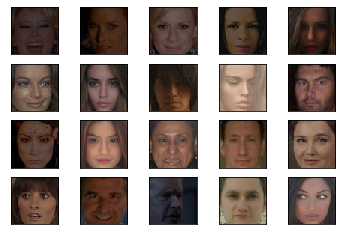

<Figure size 432x288 with 0 Axes>

In [15]:
lab3.plot_k(epistemic_images[:20]) # samples with the LEAST epistemic uncertainty

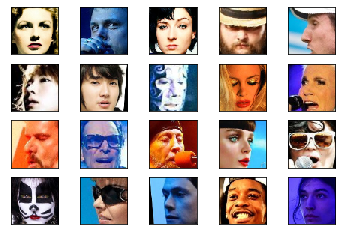

<Figure size 432x288 with 0 Axes>

In [16]:
lab3.plot_k(epistemic_images[-20:]) # samples with the MOST epistemic uncertainty

Let's run the same analysis: check how the accuracy varies with epistemic uncertainty!

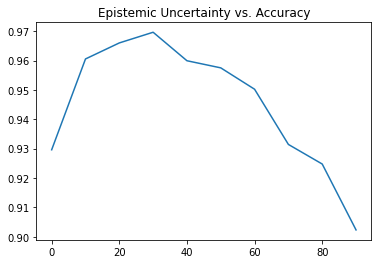

<Figure size 432x288 with 0 Axes>

In [18]:
_ = lab3.plot_accuracy_vs_risk(epistemic_images, sorted_epistemic, sorted_epistemic_preds, "Epistemic Uncertainty vs. Accuracy")

How do these compare to the bias plots? Was this expected or unexpected?

# 3.4 Resampling based on risk metrics

Finally, let's use both the bias score and the reconstruction loss to adaptively resample from our dataset. Since we can calculate this score on-the-fly *during training*, we can adjust the probability of samples being chosen. 

Note that we want to debias and amplify only the *positive* samples in the dataset, so we're going to only adjust probabilities and calculate scores for these samples. 

We want to *amplify*, or increase the probability of sampling, of images with high epistemic uncertainty, since these data points come from areas of the latent distribution that the model hasn't learned very well yet. We also want to amplify images with very low representation bias, since otherwise, the model won't see enough of these samples during training. Let's define two functions below to do this:

First, let's do this for the bias. We have a smoothing parameter `alpha` that we can tune: as `alpha` increases, the probabilities will tend towards a uniform distribution, and as `alpha` decreases, the probabilities will correlate more directly with the bias. 

In [19]:
def score_to_probability_bias(score, alpha):
    score = score + alpha
    probabilities = 1/score
    probabilities = probabilities/sum(probabilities)
    return probabilities

Let's now define a similar function for the epistemic probabilities: note that in this case, we want high epistemic uncertainty to correlate with a higher probability!

In [20]:
def score_to_probability_epistemic(score, beta):
    score = score + beta
    probabilities = score/sum(score)
    return probabilities

Now, let's redefine and re-train our debiasing model!

In [26]:
standard_classifier = make_standard_classifier()
dbvae = HistogramVAEWrapper(standard_classifier, latent_dim=100, num_bins=5, queue_size=2000, decoder=make_face_decoder_network())
dbvae.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()])
train_imgs = train_loader.get_all_faces()

In [27]:
# The training loop -- outer loop iterates over the number of epochs
for i in range(6):

  print("Starting epoch {}/{}".format(i+1, 6))
  
  # get a batch of training data and compute the training step
  for step, data in enumerate(train_loader):
    metrics = dbvae.train_step(data)
    if step % 100 == 0:
        print(step)
  _, recon_loss, bias_scores = dbvae(train_imgs)
  recon_loss = np.squeeze(recon_loss)

  # Recompute data sampling proabilities
  p_faces = score_to_probability_bias(bias_scores.numpy(), 1e-7)
  p_recon = score_to_probability_epistemic(recon_loss, 1e-7)
  p_final = (p_faces + p_recon)/2
  p_final /= sum(p_final)
  
  train_loader.p_pos = p_final

Starting epoch 1/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
Starting epoch 2/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
Starting epoch 3/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
Starting epoch 4/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
Starting epoch 5/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
Starting epoch 6/6
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


Now, we should have a debiased model that also mitigates some forms of uncertainty! Let's see how well our model does:

# 3.5 Evaluation

Let's run the same analyses as before, and plot the accuracy vs. the bias and accuracy vs. epistemic uncertainty. We want the model to do better on less biased and more uncertain samples than it did previously


In [28]:
predictions, reconstruction_loss, bias = dbvae.predict(test_imgs)

516/516 [==============================] - 11s 20ms/step


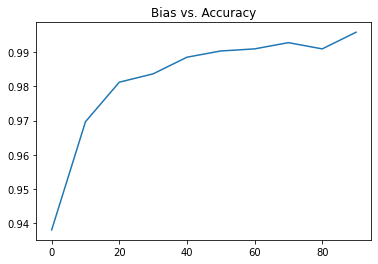

<Figure size 432x288 with 0 Axes>

In [31]:
indices = np.argsort(bias, axis=None)
bias_images = test_imgs[indices]
sorted_bias = bias[indices]
sorted_bias_preds = predictions[indices]
_ = lab3.plot_accuracy_vs_risk(bias_images, sorted_bias, sorted_bias_preds, "Bias vs. Accuracy")

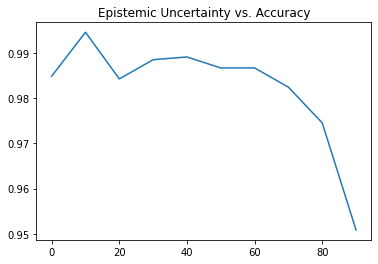

<Figure size 432x288 with 0 Axes>

In [32]:
indices = np.argsort(reconstruction_loss, axis=None)
epistemic_images = test_imgs[indices]
sorted_epistemic = bias[indices]
sorted_epistemic_preds = predictions[indices]
_ = lab3.plot_accuracy_vs_risk(epistemic_images, sorted_epistemic, sorted_epistemic_preds, "Epistemic Uncertainty vs. Accuracy")

# 3.6 Conclusion

We encourage you to think about and maybe even address some questions raised by the approach and results outlined here:

* We did not analyze the *aleatoric* uncertainty of the above dataset. Try to develop a similar approach (assigning probabilities based on aleatoric uncertainty) and incorporate this as well! You may find some surprising results :)

* How can the performance of the classifier above be improved even further? We purposely did not optimize hyperparameters to leave this up to you!

* How can you use other methods of uncertainty in CAPSA to strengthen your uncertainty estimates?

* In which applications (either related to facial detection or not!) would debiasing in this way be desired? Are there applications where you may not want to debias your model?

* Try to optimize your model to achieve improved performance. MIT students and affiliates will be eligible for prizes during the IAP offering. To enter the competition, MIT students and affiliates should upload the following to the course Canvas:

* Jupyter notebook with the code you used to generate your results;
copy of the line plots from section 3.5 showing the performance of your model;
* a description and/or diagram of the architecture and hyperparameters you used -- if there are any additional or interesting modifications you made to the template code, please include these in your description;
* discussion of why these modifications helped improve performance.

Hopefully this lab has shed some light on a few concepts, from vision based tasks, to VAEs, to algorithmic bias. We like to think it has, but we're biased ;).